# IBM Streams HDFS sample application
This sample demonstrates creating a Streams Python application to connect to HDFS, perform some file operations on a HDFS, and viewing the results.

In this notebook, you'll see examples of how to:
- [Setup](#setup)
- [Create HDFS credentials](#credentials)
- [Create the application](#create)
- [Submit the application](#submit)
- [Connect to the running application to view data](#view)

# Overview
**About the sample**

This application simulates data tuples that are inserted into a HDFS file (`write`) and reads all lines from a HDFS file. (`read`) <br/>
The function `scan` scans a Hadoop Distributed File System directory for new or modified files and returns the file names.

**How it works**
   
The Python application created in this notebook is submitted to the IBM Streams service for execution. Once the application is running in the service, you can connect to it from the notebook to retrieve the results.

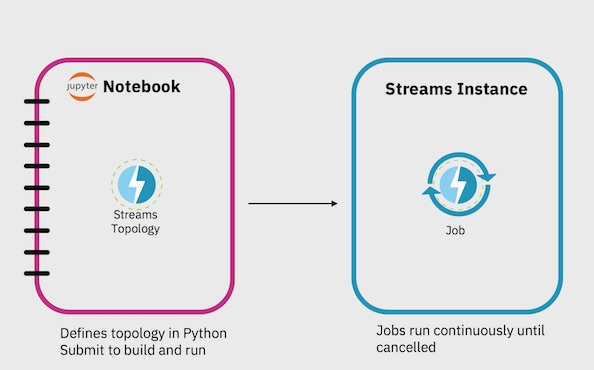


### Documentation
- [Streams Python development guide](https://ibmstreams.github.io/streamsx.documentation/docs/latest/python/)
- [Streams Python API](https://streamsxtopology.readthedocs.io/)



## <a name="setup"> </a> 1. Setup

 

### 1.1 Add credentials for the IBM Streams service

In order to submit a Streams application you need to provide the name of the Streams instance.

1. From the navigation menu, click **Services > Instances**.
2. Update the value of `streams_instance_name` in the cell below according to your Streams instance name.

In [ ]:
from icpd_core import icpd_util
streams_instance_name = "streams" ## Change this to Streams instance

try:
    cfg=icpd_util.get_service_instance_details(name=streams_instance_name, instance_type="streams")
except TypeError:
    cfg=icpd_util.get_service_instance_details(name=streams_instance_name)

### 1.2 Import  the `streamsx.hdfs` package and verify the package version

In [ ]:
#!pip install streamsx
#!pip install streamsx.hdfs

import streamsx.hdfs as hdfs
import streamsx.topology.context
print("INFO: streamsx package version: " + streamsx.topology.context.__version__)
print("INFO: streamsx.hdfs package version: " + hdfs.__version__)

### <a name="credentials"> </a> 1.3 Configure the connection to HDFS

We need a HDFS credentials as JSON string to connect to a HDFS file system. This JSON string contains the HDFS credentials `user`, `password` and `webhdfs`.

To create a HDFS credentials, please perform the following steps:

- Create an IBM Analytic Engine (1.2) service on IBM cloud. <br/>
  You need to have an IBM account to create an IAE service. <br/>
  https://console.bluemix.net/catalog/?search=Analytics Engine

- Copy the webhdfs hostname and the port and put it as `webhdfs` property into JSON string.
- Reset the password as described in: <br/>
     https://cloud.ibm.com/docs/services/AnalyticsEngine?topic=AnalyticsEngine-retrieve-cluster-credentials  <br>/
     And copy the created password und put it as value of password property into JSON string.
- Get the user name from IAE service credential und put it as value of `user` property into JSON string.
  
- Create a JSON string with the following attributes:
```
{
  "user": "your-hdfs-user-name",
  "password": "your-hdfs-password",
  "webhdfs": "webhdfs://your-hdfs-hostname:8443"
}
```
- The JSON string begins with `{` and ends with `}`.


There are 2 options to put the HDFS credentials:

1- Copy the credentials JSON string as described above in your clipboard and paste the credentials into `HDFS credentials:` prompt below.

In [ ]:
import getpass
hdfs_credentials=getpass.getpass('HDFS credentials:')
print (hdfs_credentials)

2- Perform the steps [Connecting to data source](https://www.ibm.com/support/producthub/icpdata/docs/content/SSQNUZ_current/cpd/access/connect-data-sources.html)
and create an external configuration from type `GenericWebHDFS` and put the connection name in the next step.


In [ ]:
connection_name = 'WebHDFS'
hdfs_credentials=icpd_util.get_connection(connection_name, conn_class='external')
print(hdfs_credentials) 

## <a name="create"> </a> 2. Create the Topology
All Streams applications start with a Topology object, so start by creating one topology (topo). <br/>
And import the python wrapper for streamsx.hdfs toolkit (hdfs).


In [ ]:
#Imports
from streamsx.topology.topology import *
from streamsx.topology.context import *
from streamsx.topology.schema import StreamSchema
import streamsx.hdfs as hdfs
import json


# create a Topology object
topo = Topology(name="hdfs", namespace="sample")

## <a name="download"> </a> 2.1. Download the latest version of streamsx.hdfs
If you want to work with the latest version of streamsx.hdfs toolkit, it is possible to download the toolkit and add the hdfs toolkit location to your topology.<br/>
The list of releases of streamsx.hdfs are in github.<br/>
https://github.com/IBMStreams/streamsx.hdfs/releases<br/>


In [ ]:
#hdfs_toolkit_location = hdfs.download_toolkit()
#streamsx.spl.toolkit.add_toolkit(topo, hdfs_toolkit_location)


### How to use the streamsx.hdfs package

The streamsx.hdfs package is the Python wrapper for the [streamsx.hdfs](https://ibmstreams.github.io/streamsx.hdfs/doc/spldoc/html) toolkit

Python package documentation: http://streamsxhdfs.readthedocs.io/

## <a name="sink"> </a> 2.2. Sink streaming data in a HDFS file

Next, we generate a stream of data and write this data in a HDFS file.<br/>
But before we start the application, we have to create an HDFS test directory on our hadoop server.<br/>
The directory name is in our test: `pytest` . <br/>
Login to the hadoop server and start the haddop fs shell tool and create a test directory. <br/>
For example:
```
hadoop fs -mkdir /user/hdfs/pytest 
```  

or for IAE:

```
hadoop fs -mkdir /user/clsadmin/pytest 
```  
In the first step we write one line in a HDFS file. <br/>
The function `fileSinkInputStream` creates a stream that contains one line. <br/> 
The function `hdfs.write` is the python wrapper of operator `HDFS2FileSink` .<br/>
It gets the data streams from `fileSinkInputStream` as input and inserts created lines into a HDFS file.

In [ ]:
dir_name = 'pytest'

# creates an input stream and a simple file name
fileSinkInputStream = topo.source(['This line will be written into a HDFS file.']).as_string()
fileSinkResults = hdfs.write(fileSinkInputStream, credentials=hdfs_credentials, file=dir_name + '/sample_1.txt')
fileSinkResults.print(name='printFileSinkResults') 

## <a name="dynamic_file_sink"> </a> 2.3. Sink streaming data with dynamic file names into HDFS
In the next step we write some lines in several files (dynamic file names).

In [ ]:
# create dynamic file names
# generates some data with 2 strings schema (Line, FileName)
def generate_data():
    for counter in range(0, 500):
        #yield a random id, name and age
        yield  {"Line" : "This is tuple number " + str(counter), "FileName": dir_name + '/sample_' + str(int(counter/50)) + "_%TIME.txt"}
        time.sleep(0.02)

# convert it to SPL schema for the HDFS2FileSink oper.
tuple_schema = StreamSchema("tuple<rstring Line, rstring FileName>")

# Generates data for a stream created by generate_data of two string attributes.
genData = topo.source(generate_data, name="GeneratedData").map(lambda tpl: (tpl["Line"], tpl["FileName"]), schema=tuple_schema)

# prints the output streams of genData
genData.print(name='printGenData')

# The 'fileAttributeName' points to an attribute containing the filename. The operator will close a file when value of this attribute changes.
dynamicFileSinkResults = hdfs.write(genData, credentials=hdfs_credentials, file=None, fileAttributeName='FileName')
dynamicFileSinkResults.print(name='printdynamicFileSinkResults') 

## <a name="scan"> </a> 2.4. Scan all lines from the HDFS file
In the next step we scan all files from a HDFS directory.<br/>
The function `hdfs.scan` is the python wrapper of operator `HDFS2DiectoryScan` and scans a Hadoop Distributed File System directory for new or modified files and returns the file names.<br/>
The parameter `init_delay` specifies the time to wait in seconds before the operator scans the files. <br/>
The parameter `directory` specifies the name of the directory to be scanned. <br/>
The parameter `pattern`  limits the file names that are listed to the names that match the specified regular expression. <br/>
The parameter `strictMode` determines whether the operator reports an error if the directory to be scanned does not exist. 

In [ ]:
# scans an HDFS directory and return all txt file names that begins with sample (HDFS2DirectoryScan)
scannedFileNames = hdfs.scan(topo, credentials=hdfs_credentials, directory=dir_name, pattern='sample.*txt', init_delay=10)

# prints scanned file names.
scannedFileNames.print(name='printScannedFileNames')

## <a name="get"> </a> 2.5. Read lines from the HDFS file
Now we read lines from files. <br/>
The function `hdfs.read` is the python wrapper of operator `HDFS2FielSource` . <br/>
It gets scanned file names from `scan` as input stream, opens the files to read and returns the lines of files. <br/>

In [ ]:
# reads lines from a HDFS file (HDFS2FileSource)
readLines = hdfs.read(scannedFileNames, credentials=hdfs_credentials)

# prints lines 
readLines.print(name='printReadLines')

## <a name="create_view"> </a> 2.6. Create view to show lines from HDFS files.

In [ ]:
# create a view to retrieve lines from a file
readView = readLines.view(name="readLines", description="shows the lines file HDFS files.")

# <a name="submit"> </a> 3. Submit the application

A running Streams application is called a *job*. This next cell submits the application for execution and prints the resulting job id.

In [ ]:
from streamsx.topology import context

# Disable SSL certificate verification if necessary
cfg[context.ConfigParams.SSL_VERIFY] = False
# submit the topology 'topo'
submission_result = context.submit ("DISTRIBUTED", topo, config = cfg)

# The submission_result object contains information about the running application, or job
if submission_result.job:
    streams_job = submission_result.job
    print ("JobId: ", streams_job.id , "\nJob name: ", streams_job.name)

# <a name="view"> </a> 4. View lines from files
Now that the job is started, use the View object you have already created to start retrieving lines from HDFS files.

In [ ]:
# Connect to the view and display the lines from HDFS files
queue = readView.start_data_fetch()
try:
    for val in range(20):
        print(queue.get(timeout=60))    
finally:
    readView.stop_data_fetch()

# <a name="status"> </a> 5. See job status

The tools available to monitor the running application depend on the version of Streams and your development environment.

- **If you are using a Cloud Pak for Data 3.5 project:**  When you submit the `Topology`, you create a new <i>job run</i>. The job represents the application and the job run represents a single instance of the running application. 

    1. Open your project and click on the **Jobs** tab. This will show a list of the project's jobs.
    1. Under the **Job name** column, find your job based on the `Job Name` [printed in section 3](#submit). This will list all of the job runs for that job.
    1. Click the **Run name** to open the job run. The run name will be the same as the `Job Name` printed above.
    

- **For all other development environments and versions of Streams**, [see this page for more information](http://ibmstreams.github.io/streamsx.documentation/docs/spl/quick-start/qs-4).

# <a name="cancel"></a> 6. Cancel the job

The Streams job is running in the Streams service. You can cancel it within the notebook or delete it from **Projects** > **Jobs**.


In [ ]:
# cancel the job directly using the Job object
streams_job.cancel()

## Summary
In this sample we created an HDFS application which connects to the Hadoop server, inserted some lines in HDFS files and scans a HDFS directory and reads the lines from HDFS files.

After submitting the application to the Streams service, we checked the application logs to see the progress. <br/>

It is also possible to check the contents of the test directory on the HDFS server with the following `hadoop fs` command. <br/>

In this example the hdfsUser is `clsadmin`

```
hadoop fs -ls /user/clsadmin/pytest
```
You can delete the test files with this command.   
```
hadoop fs -rm /user/clsadmin/pytest/*.*
```


### Next steps
Learn more about the [Python API from the documentation](https://streamsxtopology.readthedocs.io/en/stable/index.html/). You can also visit the [Streams community for more resources](https://ibm.biz/streams-articles).

